In [1]:
import math
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import sympy
from scipy import integrate
import sys
import random
from scipy import stats

In [2]:
def random_constant_model(target_func, n=2,noisy=0,sigma=0.1):
    mu = 0 # mean and standard deviation
    noise = np.random.normal(mu, sigma, n)
    x = [random.uniform(-1.0,1.0) for i in range(n)]
    y = target_func(x, noise, noisy)
    x_avg = np.average(x)
    y_avg = np.average(y)
    return (x_avg,y_avg,x,y)

def random_linear_origin_model(target_func, n=2, noisy=0, sigma=0.1):
    mu = 0 # mean and standard deviation
    noise = np.random.normal(mu, sigma, n)
    x = [random.uniform(-1, 1) for i in range(n)]
    y = target_func(x, noise, noisy)
    x = np.array(x)
    y = np.array(y)

    x_transpose = x.transpose()

    return (np.dot(x_transpose,y)/np.dot(x_transpose,x) , x , y)

def random_linear_model(target_func, n=2, noisy=0, sigma=0.1, seed=1):
    mu = 0 # mean and standard deviation
    np.random.seed(seed)
    noise = np.random.normal(mu, sigma, n)
    x = [float(random.uniform(-1.0,1.0)) for i in range(n)]
    y = target_func(x, noise, noisy)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return (float(intercept), float(slope), x, y)

def abline(slope, intercept, color, linewidth = 0.1):
    """Plot a line from slope and intercept"""
    x_vals = np.linspace(-1, 1, 1000)
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', color=color, linewidth = linewidth)
    return y_vals

def var_constant_model(sample_model, avg_model):
    sample_model = np.array(sample_model)
    var = np.average(sample_model**2) - (avg_model**2)
    return var

def bias_constant_model(avg_model, target_func):
    bias = 0
    x_vals = np.linspace(-1, 1, 1000)
    for x in x_vals:
        bias += (avg_model - target_func([x],[0],0)[0])**2
    bias /= len(x_vals)
    return bias

def var_one_model(slope, intercept, slope_avg, intercept_avg):
    # only one model
    var_list = []
    x_vals = np.linspace(-1, 1, 1000)
    for x in x_vals:
        y_model = slope*x + intercept
        y_avg = slope_avg*x + intercept_avg
        var_list.append((y_model - y_avg)**2)
    return np.array(var_list)

def var_linear_model(slope_sample, intercept_sample, slope_avg, intercept_avg):
    variance_list = []
    var_list = []
    for i in range(len(slope_sample)):
        slope = slope_sample[i]
        intercept = intercept_sample[i]
        var = var_one_model(slope, intercept, slope_avg, intercept_avg)
        var_list.append(var)
        variance_list.append(np.average(var))
    return variance_list , sum(var_list)/len(var_list)

def bias_linear_model(slope_avg,intercept_avg,target_func):
    x_vals = np.linspace(-1, 1, 1000)
    bias = 0
    for x in x_vals:
        bias += ((slope_avg*x + intercept_avg) - target_func([x],[0],0))**2
    bias /= len(x_vals)
    return bias

def bias_linear_model_noise(slope_avg,intercept_avg,x_positions,y_positions):
    bias = 0
    for i in range(len(y_positions)):
        bias += ((slope_avg*x_positions[i] + intercept_avg) -y_positions[i])**2
    bias /= len(y_positions)
    return bias

In [3]:
def sin_pi(x, noise, noisy):
    return [math.sin(x[i]*math.pi)+(noise[i]*noisy) for i in range(len(x))]

def square(x, noise, noisy):
    return [x[i]**2 + (noise[i]*noisy) for i in range(len(x))]

# 1. หาค่าความเอนเอียงและความแปรปรวนด้วย analytical method และ simulation ของแบบจำลองค่าคงที่และแบบจำลองเชิงเส้น แบบจำลองเชิงเส้นผ่านจุดกำเนิด

## 1.1 เมื่อกำหนดให้ฟังก์ชันเป้าหมายคือ sin(pi*x) และสุ่มข้อมูลด้วยการแจกแจงแบบเอกรูปออกมา 2 ตัวอย่างในช่วง [-1,1]

### Analytical Method

**Constant Model, Target f(x) = sin(pi*x)**

In [2]:
# Constant Model, Target f(x) = sin(pi*x)

x = sympy.Symbol("x")
x1 = sympy.Symbol("x1")
x2 = sympy.Symbol("x2")

c_model = (sympy.sin(sympy.pi*x1) + sympy.sin(sympy.pi*x2)) / 2
g_bar = (1/4)*sympy.integrate(c_model, (x1, -1, 1), (x2, -1, 1))
print("g_bar:", g_bar)

bias_order_2 = (g_bar - sympy.sin(sympy.pi*x))**2
expected_bias_order_2 = (1/2) * sympy.integrate(bias_order_2, (x, -1, 1))
print("bias^2:", expected_bias_order_2)

var = (1/4) * sympy.integrate(c_model**2, (x1, -1, 1), (x2, -1, 1)) - g_bar ** 2
variance = (1/2) * sympy.integrate(var, (x, -1, 1))
print("variance:", variance)

E_over_dataset = expected_bias_order_2 + variance
print("E_over_dataset:", E_over_dataset)

g_bar: 0
bias^2: 0.500000000000000
variance: 0.250000000000000
E_over_dataset: 0.750000000000000


In [3]:
g_bar_vec = np.vectorize(sympy.lambdify([x], g_bar, "numpy"))
var_vec = np.vectorize(sympy.lambdify([x], var, "numpy"))

# Sample data for the x-axis
x_vals = np.linspace(-1, 1, 1000)

# Sample data for the upper and lower bounds of the filled area
upper_bound = g_bar_vec(x_vals) + np.sqrt(var_vec(x_vals))
lower_bound = g_bar_vec(x_vals) - np.sqrt(var_vec(x_vals))

# Create the area graph using Plotly
fig = go.Figure()

# Add the filled area trace
fig.add_trace(go.Scatter(x=x_vals, y=upper_bound, mode='lines', line=dict(color='rgba(0, 0, 255, 0)'), name='Upper Bound'))
fig.add_trace(go.Scatter(x=x_vals, y=lower_bound, mode='lines', line=dict(color='rgba(0, 0, 255, 0)'), name='Lower Bound'))
fig.add_trace(go.Scatter(x=x_vals, y=upper_bound, fill='tonexty', mode='none', fillcolor='rgba(0, 0, 255, 0.3)', name='Area'))

# Add the function line
fig.add_trace(go.Scatter(x=x_vals, y= np.sin(math.pi * x_vals), mode='lines', line=dict(color='rgba(255, 0, 0, 1)'), name='Target Function'))
fig.add_trace(go.Scatter(x=x_vals, y=g_bar_vec(x_vals), mode='lines', line=dict(color='rgba(0, 0, 255, 1)'), name='g_bar'))


# Customize layout
fig.update_layout(title='Constant Model, Target f(x) = sin(pi*x)',
                  xaxis_title='X-axis',
                  yaxis_title='Y-axis',
                  legend=dict(x=0, y=1),
                  showlegend=False,
                  yaxis_range=[-2,2],
                  margin=go.layout.Margin(
                  l=0, #left margin
                  r=400, #right margin
                  b=0, #bottom margin
                  t=30, #top margin
                ))

# Show the plot
fig.show()

**Linear Model through the origin, Target f(x) = sin(pi*x)**

In [4]:
# Linear Model through the origin, Target f(x) = sin(pi*x)

x = sympy.Symbol("x", real = True)
x1 = sympy.Symbol("x1")
x2 = sympy.Symbol("x2")

slope_sym = (((x1 * sympy.sin(sympy.pi*x1)) + (x2 * sympy.sin(sympy.pi*x2))) / (x1 ** 2 + x2 ** 2))
slope = sympy.lambdify([x1,x2], slope_sym, "numpy")
model = slope_sym * x
g_bar = (1/4) * (integrate.dblquad(slope, -1, 0, -1, 1)[0] + integrate.dblquad(slope, 0, 1, -1, 1)[0]) * x
print("g_bar:", g_bar)

bias_order_2 = (g_bar - sympy.sin(sympy.pi*x))**2
expected_bias_order_2 = sympy.N((1/2) * sympy.integrate(bias_order_2, (x, -1, 1)))
print("bias^2:", expected_bias_order_2)

prep = sympy.lambdify([x1,x2], slope_sym**2, "numpy")
var = (1/4) * (integrate.dblquad(prep, -1, 1, 0, 1)[0] + integrate.dblquad(prep, -1, 1, -1, 0)[0]) * x**2 - g_bar ** 2
variance = (1/2) * sympy.integrate(var, (x, -1, 1))
print("variance:", variance)

E_over_dataset = expected_bias_order_2 + variance
print("E_over_dataset:", E_over_dataset)

g_bar: 1.42802717484247*x
bias^2: 0.270643535713256
variance: 0.236575925913684
E_over_dataset: 0.507219461626941


In [5]:
**Linear Model through the origin, Target f(x) = sin(pi*x)**

**Linear Model, Target f(x) = sin(pi*x)**

In [8]:
# Linear Model, Target f(x) = sin(pi*x)

x = sympy.Symbol("x", real = True)
x1 = sympy.Symbol("x1")
x2 = sympy.Symbol("x2")

slope = (sympy.sin(sympy.pi*x1) - sympy.sin(sympy.pi*x2)) / (x1 - x2)
model = (sympy.sin(sympy.pi*x2) - slope * x2) + slope * x # w0 + w1x

inte_slope = integrate.dblquad(sympy.lambdify([x1, x2], slope), -1, 0, -1, 1)[0] + integrate.dblquad(sympy.lambdify([x1, x2], slope), 0, 1, -1, 1)[0]
inte_slope_time_x2 = integrate.dblquad(sympy.lambdify([x1, x2], slope * x2), -1, 0, -1, 1)[0] + integrate.dblquad(sympy.lambdify([x1, x2], slope * x2), 0, 1, -1, 1)[0]

g_bar = (1/4)*(sympy.integrate(sympy.sin(sympy.pi*x2), (x1, -1, 1), (x2, -1, 1)) - inte_slope_time_x2 + inte_slope * x)
print("g_bar:", g_bar)

bias_order_2 = (g_bar - sympy.sin(sympy.pi*x))**2
expected_bias_order_2 = sympy.N((1/2) * sympy.integrate(bias_order_2, (x, -1, 1)))
print("bias^2:", expected_bias_order_2)

pre_var = sympy.lambdify([x1, x2, x], (sympy.simplify(model) - g_bar)**2, "numpy")
variance = (1/8) * (integrate.tplquad(pre_var, -1, 1, 0, 1, -1, 1)[0] + integrate.tplquad(pre_var, -1, 1, -1, 0, -1, 1)[0])
print("variance:", variance)

E_over_dataset = expected_bias_order_2 + variance
print("E_over_dataset:", E_over_dataset)

g_bar: 0.775929174099576*x
bias^2: 0.206716840217646
variance: 1.676282395045049
E_over_dataset: 1.88299923526269


## Simulation Method

**Constant Model, Target f(x) = sin(pi*x)**

In [13]:
n = 10000
sample_model = []
for i in range(n):
    x, y = random_constant_model(sin_pi)[0:2]
    sample_model.append(y)

avg_model = np.average(sample_model)
print("avg model:", avg_model)

avg model: -0.004145772666867229


array([-0.00414577, -0.00414577, -0.00414577, -0.00414577, -0.00414577,
       -0.00414577, -0.00414577, -0.00414577, -0.00414577, -0.00414577,
       -0.00414577, -0.00414577, -0.00414577, -0.00414577, -0.00414577,
       -0.00414577, -0.00414577, -0.00414577, -0.00414577, -0.00414577,
       -0.00414577, -0.00414577, -0.00414577, -0.00414577, -0.00414577,
       -0.00414577, -0.00414577, -0.00414577, -0.00414577, -0.00414577,
       -0.00414577, -0.00414577, -0.00414577, -0.00414577, -0.00414577,
       -0.00414577, -0.00414577, -0.00414577, -0.00414577, -0.00414577,
       -0.00414577, -0.00414577, -0.00414577, -0.00414577, -0.00414577,
       -0.00414577, -0.00414577, -0.00414577, -0.00414577, -0.00414577,
       -0.00414577, -0.00414577, -0.00414577, -0.00414577, -0.00414577,
       -0.00414577, -0.00414577, -0.00414577, -0.00414577, -0.00414577,
       -0.00414577, -0.00414577, -0.00414577, -0.00414577, -0.00414577,
       -0.00414577, -0.00414577, -0.00414577, -0.00414577, -0.00

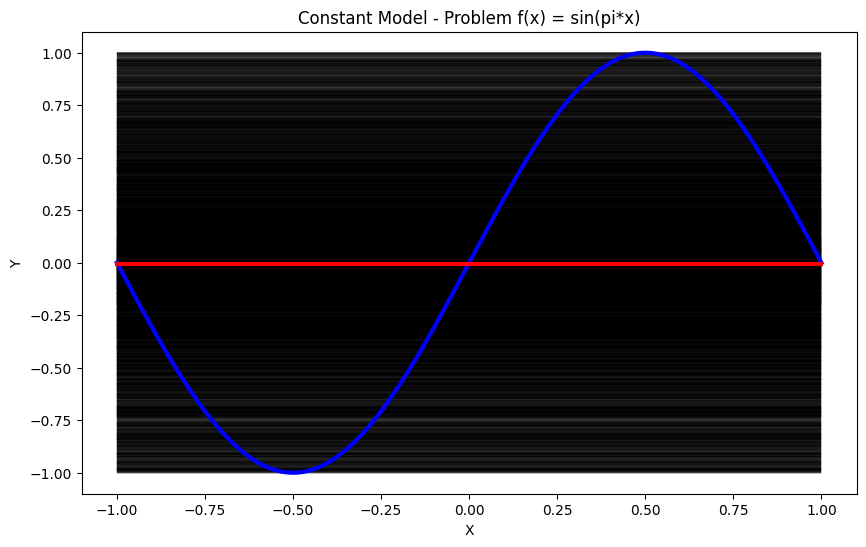

In [14]:
plt.figure(figsize=(10,6))
plt.title("Constant Model - Problem f(x) = sin(pi*x)")
plt.xlabel("X")
plt.ylabel("Y")

# Sample model graph
for y in sample_model:
    abline(0, y, 'k')

# Sin graph
points_amt = 1000
x_vals = np.linspace(-1, 1, points_amt)
y_vals = sin_pi(x_vals,[x]*points_amt,0)
plt.plot(x_vals, y_vals, '-', color='b', linewidth=3)

# avg line
abline(0, avg_model, 'r', 3)

In [15]:
print("var:", var_constant_model(sample_model, avg_model))
print("bias:", bias_constant_model(avg_model, sin_pi))

var: 0.24919839880750339
bias: 0.49951718743100576


**Linear Model through the origin, Target f(x) = sin(pi*x)**

In [19]:
n = 10000
slope_sample = []

for i in range(n):
    slope = random_linear_origin_model(sin_pi)[0]
    slope_sample.append(slope)

intercept_sample = [0] * len(slope_sample)
intercept_avg = 0
slope_avg = np.average(slope_sample)
print("avg slope:", slope_avg)

avg slope: 1.425283778443767


array([-1.42528378, -1.42243036, -1.41957694, -1.41672352, -1.41387009,
       -1.41101667, -1.40816325, -1.40530983, -1.40245641, -1.39960299,
       -1.39674957, -1.39389615, -1.39104273, -1.38818931, -1.38533588,
       -1.38248246, -1.37962904, -1.37677562, -1.3739222 , -1.37106878,
       -1.36821536, -1.36536194, -1.36250852, -1.3596551 , -1.35680167,
       -1.35394825, -1.35109483, -1.34824141, -1.34538799, -1.34253457,
       -1.33968115, -1.33682773, -1.33397431, -1.33112089, -1.32826747,
       -1.32541404, -1.32256062, -1.3197072 , -1.31685378, -1.31400036,
       -1.31114694, -1.30829352, -1.3054401 , -1.30258668, -1.29973326,
       -1.29687983, -1.29402641, -1.29117299, -1.28831957, -1.28546615,
       -1.28261273, -1.27975931, -1.27690589, -1.27405247, -1.27119905,
       -1.26834562, -1.2654922 , -1.26263878, -1.25978536, -1.25693194,
       -1.25407852, -1.2512251 , -1.24837168, -1.24551826, -1.24266484,
       -1.23981141, -1.23695799, -1.23410457, -1.23125115, -1.22

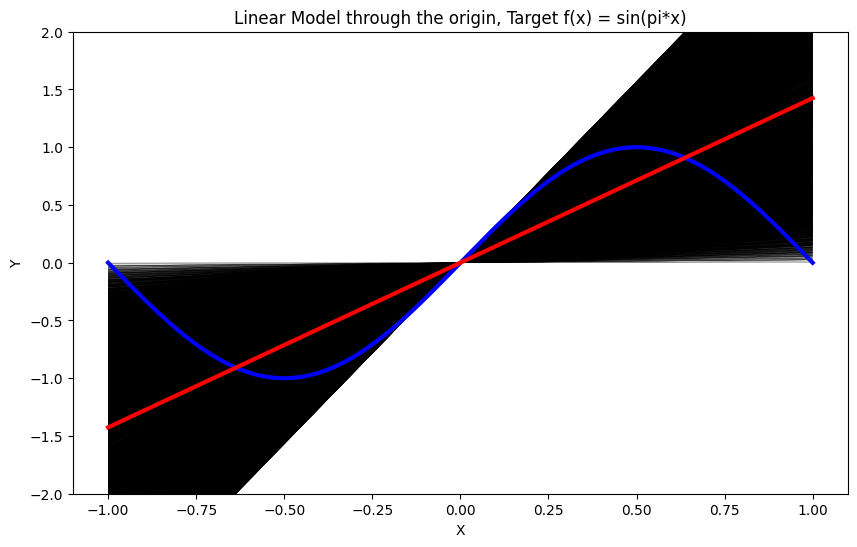

In [20]:
plt.figure(figsize=(10,6))
plt.ylim(-2,2)
plt.title("Linear Model through the origin, Target f(x) = sin(pi*x)")
plt.xlabel("X")
plt.ylabel("Y")

# Sample model graph
for i in range(len(slope_sample)):
    abline(slope_sample[i], 0, 'k')

# Sin graph
points_amt = 1000
x_vals = np.linspace(-1, 1, points_amt)
y_vals = sin_pi(x_vals,[0]*points_amt,0)
plt.plot(x_vals, y_vals, '-', color='b', linewidth=3)

# avg line
abline(slope_avg, intercept_avg, 'r', 3)

In [21]:
print("var:", np.average(var_linear_model(slope_sample, intercept_sample, slope_avg, intercept_avg)[0]))
print("bias:", bias_linear_model(slope_avg, intercept_avg, sin_pi)[0])

var: 0.23371550686801792
bias: 0.2715467785825333


**Linear Model, Target f(x) = sin(pi*x)**

In [25]:
n = 10000
slope_sample = []
intercept_sample = []
for i in range(n):
    intercept, slope = random_linear_model(sin_pi)[0:2]
    slope_sample.append(slope)
    intercept_sample.append(intercept)

In [26]:
slope_avg = np.average(slope_sample)
intercept_avg = np.average(intercept_sample)
print("slope_avg:", slope_avg)
print("intercept_avg:", intercept_avg)

slope_avg: 0.754839082906885
intercept_avg: 0.003457933158711991


array([-7.51381150e-01, -7.49869960e-01, -7.48358771e-01, -7.46847582e-01,
       -7.45336392e-01, -7.43825203e-01, -7.42314014e-01, -7.40802824e-01,
       -7.39291635e-01, -7.37780446e-01, -7.36269256e-01, -7.34758067e-01,
       -7.33246877e-01, -7.31735688e-01, -7.30224499e-01, -7.28713309e-01,
       -7.27202120e-01, -7.25690931e-01, -7.24179741e-01, -7.22668552e-01,
       -7.21157363e-01, -7.19646173e-01, -7.18134984e-01, -7.16623795e-01,
       -7.15112605e-01, -7.13601416e-01, -7.12090227e-01, -7.10579037e-01,
       -7.09067848e-01, -7.07556658e-01, -7.06045469e-01, -7.04534280e-01,
       -7.03023090e-01, -7.01511901e-01, -7.00000712e-01, -6.98489522e-01,
       -6.96978333e-01, -6.95467144e-01, -6.93955954e-01, -6.92444765e-01,
       -6.90933576e-01, -6.89422386e-01, -6.87911197e-01, -6.86400007e-01,
       -6.84888818e-01, -6.83377629e-01, -6.81866439e-01, -6.80355250e-01,
       -6.78844061e-01, -6.77332871e-01, -6.75821682e-01, -6.74310493e-01,
       -6.72799303e-01, -

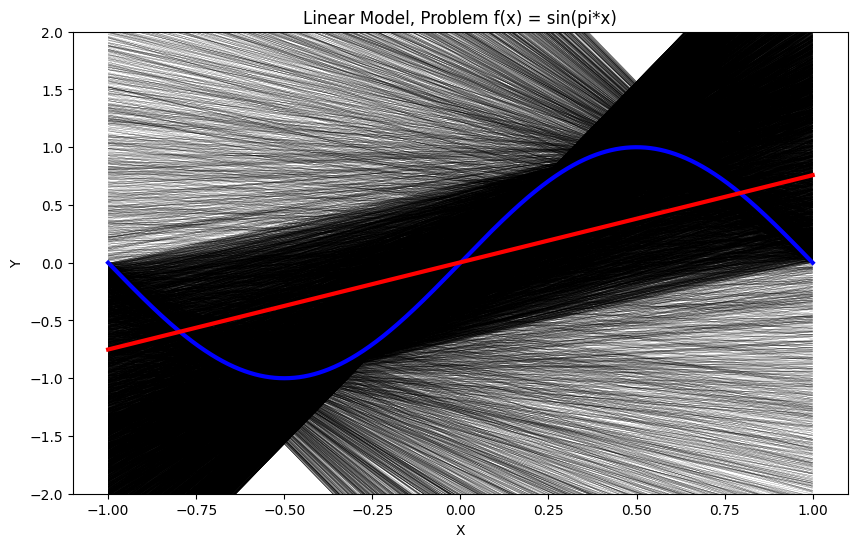

In [27]:
plt.figure(figsize=(10,6))
plt.ylim(-2,2)
plt.title("Linear Model, Problem f(x) = sin(pi*x)")
plt.xlabel("X")
plt.ylabel("Y")

# Sample model graph
for i in range(len(slope_sample)):
    abline(slope_sample[i], intercept_sample[i], 'k')

# Sin graph
points_amt = 1000
x_vals = np.linspace(-1, 1, points_amt)
y_vals = sin_pi(x_vals,[0]*points_amt,0)
plt.plot(x_vals, y_vals, '-', color='b', linewidth=3)

# avg line
abline(slope_avg, intercept_avg, 'r', 3)

In [28]:
var_linear_model_list = var_linear_model(slope_sample, intercept_sample, slope_avg, intercept_avg)
print("var:", np.average(var_linear_model_list[0]))
print("bias:", bias_linear_model(slope_avg, intercept_avg, sin_pi)[0])

var: 1.732225384942218
bias: 0.20975618212425187


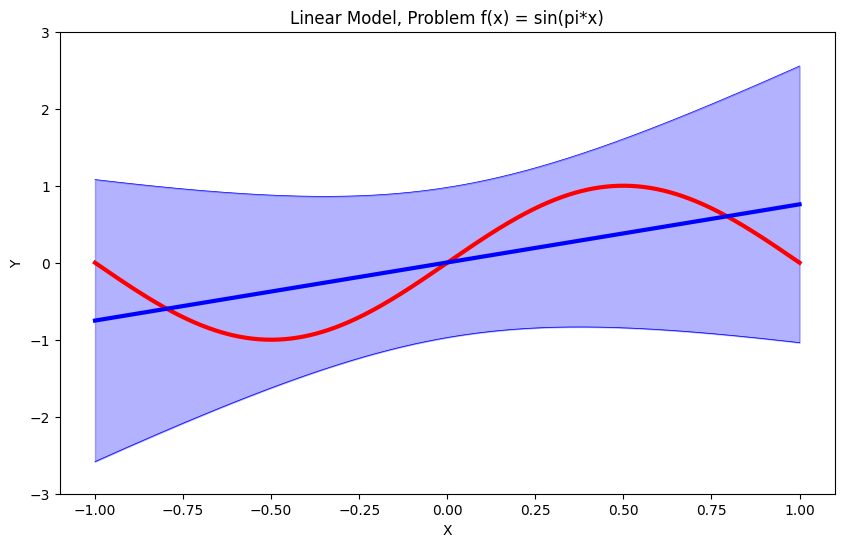

In [29]:
plt.figure(figsize=(10,6))
plt.ylim(-3,3)
plt.title("Linear Model, Problem f(x) = sin(pi*x)")
plt.xlabel("X")
plt.ylabel("Y")

# Sin graph
points_amt = 1000
x_vals = np.linspace(-1, 1, points_amt)
y_vals = sin_pi(x_vals,[0]*points_amt,0)
plt.plot(x_vals, y_vals, '-', color='r', linewidth=3)

# avg line
g_bar = abline(slope_avg, intercept_avg, 'b', 3)

var1 = (var_linear_model_list[1]**(1/2)) + np.array(g_bar)
plt.plot(x_vals, var1, '-', color='b', linewidth=0.5)

var2 = np.array(g_bar) - (var_linear_model_list[1]**(1/2))
plt.plot(x_vals, var2, '-', color='b', linewidth=0.5)
plt.fill_between(x_vals, var2, var1, color='b', alpha=0.3)

## 1.2  เมื่อกำหนดให้ฟังก์ชันเป้าหมายคือ x^2 และสุ่มข้อมูลด้วยการแจกแจงแบบเอกรูปออกมา 2 ตัวอย่างในช่วง [-1,1]

### Analytical Method

**Constant Model, Target f(x) = x^2**

In [42]:
# Constant Model, Target f(x) = x^2

x = sympy.Symbol("x")
x1 = sympy.Symbol("x1")
x2 = sympy.Symbol("x2")

c_model = (x1**2 + x2**2) / 2
g_bar = (1/4)*sympy.integrate(c_model, (x1, -1, 1), (x2, -1, 1))
print("g_bar:", g_bar)

bias_order_2 = (g_bar - x**2)**2
expected_bias_order_2 = (1/2) * sympy.integrate(bias_order_2, (x, -1, 1))
print("bias^2:", expected_bias_order_2)

var = (1/4) * sympy.integrate(c_model**2, (x1, -1, 1), (x2, -1, 1)) - g_bar ** 2
variance = (1/2) * sympy.integrate(var, (x, -1, 1))
print("variance:", variance)

E_over_dataset = expected_bias_order_2 + variance
print("E_over_dataset:", E_over_dataset)

g_bar: 0.333333333333333
bias^2: 0.0888888888888889
variance: 0.0444444444444445
E_over_dataset: 0.133333333333333


In [43]:
g_bar_vec = np.vectorize(sympy.lambdify([x], g_bar, "numpy"))
var_vec = np.vectorize(sympy.lambdify([x], var, "numpy"))

# Sample data for the x-axis
x_vals = np.linspace(-1, 1, 1000)

# Sample data for the upper and lower bounds of the filled area
upper_bound = g_bar_vec(x_vals) + np.sqrt(var_vec(x_vals))
lower_bound = g_bar_vec(x_vals) - np.sqrt(var_vec(x_vals))

# Create the area graph using Plotly
fig = go.Figure()

# Add the filled area trace
fig.add_trace(go.Scatter(x=x_vals, y=upper_bound, mode='lines', line=dict(color='rgba(0, 0, 255, 0)'), name='Upper Bound'))
fig.add_trace(go.Scatter(x=x_vals, y=lower_bound, mode='lines', line=dict(color='rgba(0, 0, 255, 0)'), name='Lower Bound'))
fig.add_trace(go.Scatter(x=x_vals, y=upper_bound, fill='tonexty', mode='none', fillcolor='rgba(0, 0, 255, 0.3)', name='Area'))

# Add the function line
fig.add_trace(go.Scatter(x=x_vals, y=x_vals**2, mode='lines', line=dict(color='rgba(255, 0, 0, 1)'), name='Target Function'))
fig.add_trace(go.Scatter(x=x_vals, y=g_bar_vec(x_vals), mode='lines', line=dict(color='rgba(0, 0, 255, 1)'), name='g_bar'))


# Optional: Customize layout
fig.update_layout(title='Linear Model through the origin, Target f(x) = x^2',
                  xaxis_title='X-axis',
                  yaxis_title='Y-axis',
                  legend=dict(x=0, y=1),
                  showlegend=False,
                  yaxis_range=[-2,2],
                  margin=go.layout.Margin(
                  l=0, #left margin
                  r=400, #right margin
                  b=0, #bottom margin
                  t=30, #top margin
                ))

# Show the plot
fig.show()

**Linear Model through the origin, Target f(x) = x^2**

In [44]:
# Linear Model through the origin, Target f(x) = x^2

x = sympy.Symbol("x", real = True)
x1 = sympy.Symbol("x1")
x2 = sympy.Symbol("x2")
w1 = sympy.Symbol("w1")

model = (((x1 ** 3) + (x2 **3)) * x / (x1 ** 2 + x2 ** 2))
g_bar = sympy.simplify((1/4)*sympy.integrate(model, (x1, -1, 1), (x2, -1, 1)))
print("g_bar:", g_bar)

bias_order_2 = (g_bar - x**2)**2
expected_bias_order_2 = (1/2) * sympy.integrate(bias_order_2, (x, -1, 1))
print("bias^2:", expected_bias_order_2)

#(1/4) * sympy.integrate(model**2, (x1, -1, 1), (x2, -1, 1)) - g_bar ** 2
test = sympy.lambdify([x1, x2], model**2 / x**2, "numpy")
var = (1/4)*(integrate.dblquad(test, -1, 0, -1, 1)[0] + integrate.dblquad(test, 0, 1, -1, 1)[0]) * x ** 2
variance = (1/2) * sympy.integrate(var, (x, -1, 1))
print("variance:", variance)

E_over_dataset = expected_bias_order_2 + variance
print("E_over_dataset:", E_over_dataset)

g_bar: 0
bias^2: 0.200000000000000
variance: 0.114921303921007
E_over_dataset: 0.314921303921007


In [45]:
g_bar_vec = np.vectorize(sympy.lambdify([x], g_bar, "numpy"))
var_vec = np.vectorize(sympy.lambdify([x], var, "numpy"))

# Sample data for the x-axis
x_vals = np.linspace(-1, 1, 1000)

# Sample data for the upper and lower bounds of the filled area
upper_bound = g_bar_vec(x_vals) + np.sqrt(var_vec(x_vals))
lower_bound = g_bar_vec(x_vals) - np.sqrt(var_vec(x_vals))

# Create the area graph using Plotly
fig = go.Figure()

# Add the filled area trace
fig.add_trace(go.Scatter(x=x_vals, y=upper_bound, mode='lines', line=dict(color='rgba(0, 0, 255, 0)'), name='Upper Bound'))
fig.add_trace(go.Scatter(x=x_vals, y=lower_bound, mode='lines', line=dict(color='rgba(0, 0, 255, 0)'), name='Lower Bound'))
fig.add_trace(go.Scatter(x=x_vals, y=upper_bound, fill='tonexty', mode='none', fillcolor='rgba(0, 0, 255, 0.3)', name='Area'))

# Add the function line
fig.add_trace(go.Scatter(x=x_vals, y=x_vals**2, mode='lines', line=dict(color='rgba(255, 0, 0, 1)'), name='Target Function'))
fig.add_trace(go.Scatter(x=x_vals, y=g_bar_vec(x_vals), mode='lines', line=dict(color='rgba(0, 0, 255, 1)'), name='g_bar'))


# Optional: Customize layout
fig.update_layout(title='Linear Model through the origin, Target f(x) = x^2',
                  xaxis_title='X-axis',
                  yaxis_title='Y-axis',
                  legend=dict(x=0, y=1),
                  showlegend=False,
                  yaxis_range=[-2,2],
                  margin=go.layout.Margin(
                  l=0, #left margin
                  r=400, #right margin
                  b=0, #bottom margin
                  t=30, #top margin
                ))

# Show the plot
fig.show()

**Linear Model, Target f(x) = x^2**

In [ ]:
# Linear Model, Target f(x) = x^2

x = sympy.Symbol("x")
x1 = sympy.Symbol("x1")
x2 = sympy.Symbol("x2")

slope = (x1**2 - x2**2) / (x1 - x2)
model = (x2**2 - slope * x2) + slope * x # w0 + w1x
g_bar = (1/4)*sympy.integrate(model, (x1, -1, 1), (x2, -1, 1))
print("g_bar:", g_bar)

bias_order_2 = (g_bar - x**2)**2
expected_bias_order_2 = (1/2) * sympy.integrate(bias_order_2, (x, -1, 1))
print("bias^2:", expected_bias_order_2)

var = (1/4) * sympy.integrate(model**2, (x1, -1, 1), (x2, -1, 1)) - g_bar ** 2
variance = (1/2) * sympy.integrate(var, (x, -1, 1))
print("variance:", variance)

E_over_dataset = expected_bias_order_2 + variance
print("E_over_dataset:", E_over_dataset)

g_bar: 0
bias^2: 0.200000000000000
variance: 0.333333333333333
E_over_dataset: 0.533333333333333


In [ ]:
g_bar_vec = np.vectorize(sympy.lambdify([x], g_bar, "numpy"))
var_vec = np.vectorize(sympy.lambdify([x], var, "numpy"))

# Sample data for the x-axis
x_vals = np.linspace(-1, 1, 1000)

# Sample data for the upper and lower bounds of the filled area
upper_bound = g_bar_vec(x_vals) + np.sqrt(var_vec(x_vals))
lower_bound = g_bar_vec(x_vals) - np.sqrt(var_vec(x_vals))

# Create the area graph using Plotly
fig = go.Figure()

# Add the filled area trace
fig.add_trace(go.Scatter(x=x_vals, y=upper_bound, mode='lines', line=dict(color='rgba(0, 0, 255, 0)'), name='Upper Bound'))
fig.add_trace(go.Scatter(x=x_vals, y=lower_bound, mode='lines', line=dict(color='rgba(0, 0, 255, 0)'), name='Lower Bound'))
fig.add_trace(go.Scatter(x=x_vals, y=upper_bound, fill='tonexty', mode='none', fillcolor='rgba(0, 0, 255, 0.3)', name='Area'))

# Add the function line
fig.add_trace(go.Scatter(x=x_vals, y=x_vals**2, mode='lines', line=dict(color='rgba(255, 0, 0, 1)'), name='Target Function'))
fig.add_trace(go.Scatter(x=x_vals, y=g_bar_vec(x_vals), mode='lines', line=dict(color='rgba(0, 0, 255, 1)'), name='g_bar'))


# Customize layout
fig.update_layout(title='Linear Model, Target f(x) = x^2',
                  xaxis_title='X-axis',
                  yaxis_title='Y-axis',
                  legend=dict(x=0, y=1),
                  showlegend=False,
                  yaxis_range=[-2,2],
                  margin=go.layout.Margin(
                  l=0, #left margin
                  r=400, #right margin
                  b=0, #bottom margin
                  t=30, #top margin
                ))

# Show the plot
fig.show()

### Simulation Method

**Constant Model, Target f(x) = x^2**

In [ ]:
n = 10000
sample_model = []
for i in range(n):
    x, y = random_constant_model(square)[0:2]
    sample_model.append(y)

avg_model = np.average(sample_model)
print("avg model:", avg_model)

avg model: 0.33176923202539466


array([0.33176923, 0.33176923, 0.33176923, 0.33176923, 0.33176923,
       0.33176923, 0.33176923, 0.33176923, 0.33176923, 0.33176923,
       0.33176923, 0.33176923, 0.33176923, 0.33176923, 0.33176923,
       0.33176923, 0.33176923, 0.33176923, 0.33176923, 0.33176923,
       0.33176923, 0.33176923, 0.33176923, 0.33176923, 0.33176923,
       0.33176923, 0.33176923, 0.33176923, 0.33176923, 0.33176923,
       0.33176923, 0.33176923, 0.33176923, 0.33176923, 0.33176923,
       0.33176923, 0.33176923, 0.33176923, 0.33176923, 0.33176923,
       0.33176923, 0.33176923, 0.33176923, 0.33176923, 0.33176923,
       0.33176923, 0.33176923, 0.33176923, 0.33176923, 0.33176923,
       0.33176923, 0.33176923, 0.33176923, 0.33176923, 0.33176923,
       0.33176923, 0.33176923, 0.33176923, 0.33176923, 0.33176923,
       0.33176923, 0.33176923, 0.33176923, 0.33176923, 0.33176923,
       0.33176923, 0.33176923, 0.33176923, 0.33176923, 0.33176923,
       0.33176923, 0.33176923, 0.33176923, 0.33176923, 0.33176

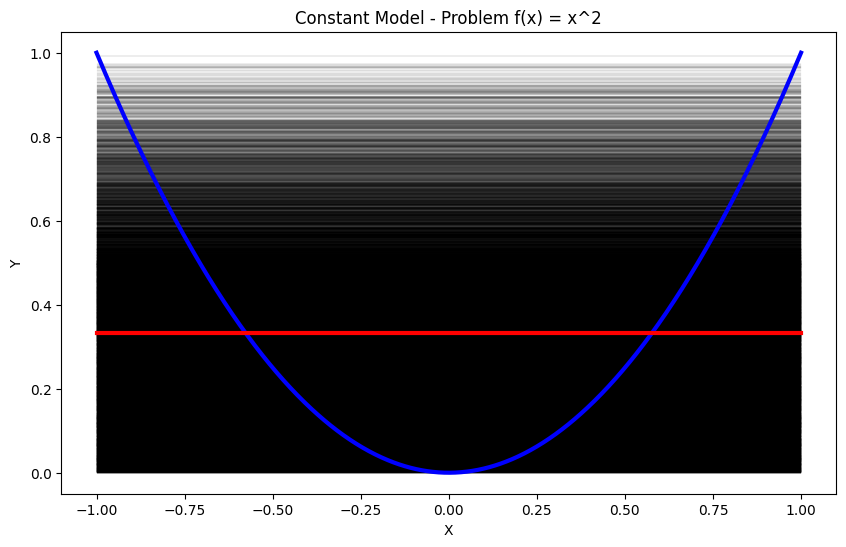

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Constant Model - Problem f(x) = x^2")
plt.xlabel("X")
plt.ylabel("Y")

# Sample model graph
for y in sample_model:
    abline(0, y, 'k')

# x^2 graph
points_amt = 1000
x_vals = np.linspace(-1, 1, points_amt)
y_vals = square(x_vals,[0]*points_amt,0)
plt.plot(x_vals, y_vals, '-', color='b', linewidth=3)

# avg line
abline(0,avg_model,'r',3)

In [ ]:
print("var:", var_constant_model(sample_model, avg_model))
print("bias:", bias_constant_model(avg_model, square))

var: 0.04442520355162756
bias: 0.0892498681914451


**Linear Model through the origin, Target f(x) = x^2**

In [ ]:
n = 10000
slope_sample = []

for i in range(n):
    slope = random_linear_origin_model(square)[0]
    slope_sample.append(slope)

intercept_sample = [0] * len(slope_sample)
intercept_avg = 0
slope_avg = np.average(slope_sample)
print("avg slope:", slope_avg)

avg slope: -0.00015923997554053847


array([ 1.59239976e-04,  1.58921177e-04,  1.58602378e-04,  1.58283579e-04,
        1.57964781e-04,  1.57645982e-04,  1.57327183e-04,  1.57008384e-04,
        1.56689586e-04,  1.56370787e-04,  1.56051988e-04,  1.55733189e-04,
        1.55414391e-04,  1.55095592e-04,  1.54776793e-04,  1.54457994e-04,
        1.54139196e-04,  1.53820397e-04,  1.53501598e-04,  1.53182799e-04,
        1.52864001e-04,  1.52545202e-04,  1.52226403e-04,  1.51907604e-04,
        1.51588806e-04,  1.51270007e-04,  1.50951208e-04,  1.50632409e-04,
        1.50313611e-04,  1.49994812e-04,  1.49676013e-04,  1.49357214e-04,
        1.49038416e-04,  1.48719617e-04,  1.48400818e-04,  1.48082019e-04,
        1.47763221e-04,  1.47444422e-04,  1.47125623e-04,  1.46806824e-04,
        1.46488026e-04,  1.46169227e-04,  1.45850428e-04,  1.45531629e-04,
        1.45212831e-04,  1.44894032e-04,  1.44575233e-04,  1.44256434e-04,
        1.43937636e-04,  1.43618837e-04,  1.43300038e-04,  1.42981239e-04,
        1.42662441e-04,  

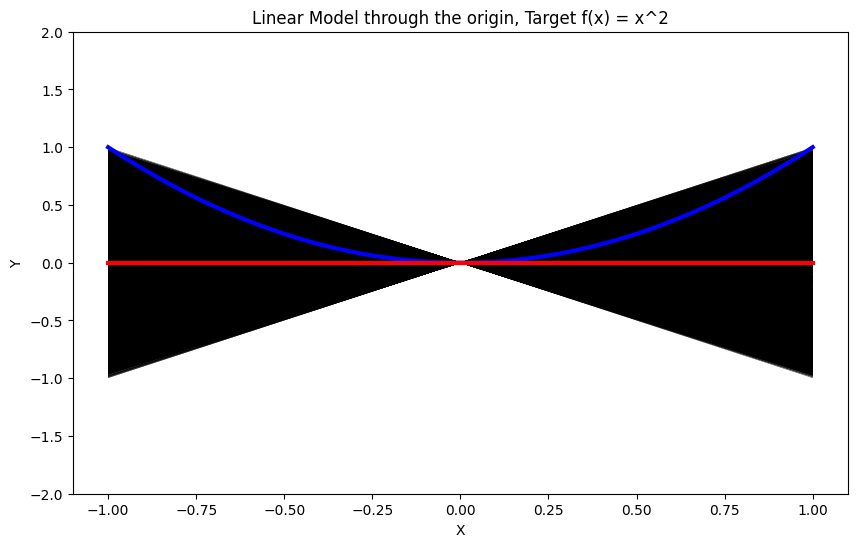

In [ ]:
plt.figure(figsize=(10,6))
plt.ylim(-2,2)
plt.title("Linear Model through the origin, Target f(x) = x^2")
plt.xlabel("X")
plt.ylabel("Y")

# Sample model graph
for i in range(len(slope_sample)):
    abline(slope_sample[i], 0, 'k')

# Sin graph
points_amt = 1000
x_vals = np.linspace(-1, 1, points_amt)
y_vals = square(x_vals,[0]*points_amt,0)
plt.plot(x_vals, y_vals, '-', color='b', linewidth=3)

# avg line
abline(slope_avg, intercept_avg, 'r', 3)

In [ ]:
print("var:", np.average(var_linear_model(slope_sample, intercept_sample, slope_avg, intercept_avg)[0]))
print("bias:", bias_linear_model(slope_avg, intercept_avg, square)[0])

var: 0.11441891461477956
bias: 0.20080134313684478


**Linear Model, Target f(x) = x^2**

In [ ]:
n = 10000
slope_sample = []
intercept_sample = []
for i in range(n):
    intercept, slope = random_linear_model(square)[0:2]
    slope_sample.append(slope)
    intercept_sample.append(intercept)

In [ ]:
slope_avg = np.average(slope_sample)
intercept_avg = np.average(intercept_sample)
print("slope_avg:", slope_avg)
print("intercept_avg:", intercept_avg)

slope_avg: 0.0007698057038170038
intercept_avg: -0.007993002289406023


array([-0.00876281, -0.00876127, -0.00875973, -0.00875818, -0.00875664,
       -0.0087551 , -0.00875356, -0.00875202, -0.00875048, -0.00874894,
       -0.0087474 , -0.00874586, -0.00874431, -0.00874277, -0.00874123,
       -0.00873969, -0.00873815, -0.00873661, -0.00873507, -0.00873353,
       -0.00873198, -0.00873044, -0.0087289 , -0.00872736, -0.00872582,
       -0.00872428, -0.00872274, -0.0087212 , -0.00871966, -0.00871811,
       -0.00871657, -0.00871503, -0.00871349, -0.00871195, -0.00871041,
       -0.00870887, -0.00870733, -0.00870579, -0.00870424, -0.0087027 ,
       -0.00870116, -0.00869962, -0.00869808, -0.00869654, -0.008695  ,
       -0.00869346, -0.00869191, -0.00869037, -0.00868883, -0.00868729,
       -0.00868575, -0.00868421, -0.00868267, -0.00868113, -0.00867959,
       -0.00867804, -0.0086765 , -0.00867496, -0.00867342, -0.00867188,
       -0.00867034, -0.0086688 , -0.00866726, -0.00866572, -0.00866417,
       -0.00866263, -0.00866109, -0.00865955, -0.00865801, -0.00

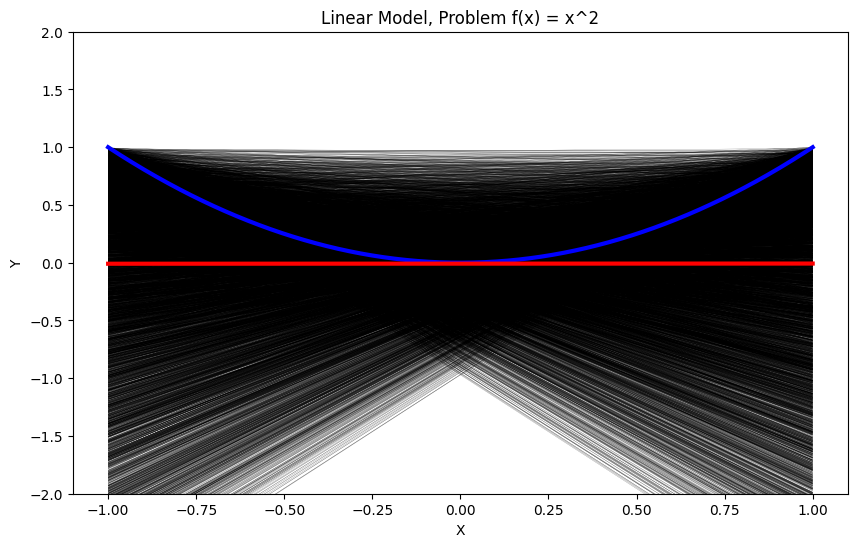

In [ ]:
plt.figure(figsize=(10,6))
plt.ylim(-2,2)
plt.title("Linear Model, Problem f(x) = x^2")
plt.xlabel("X")
plt.ylabel("Y")

# Sample model graph
for i in range(len(slope_sample)):
    abline(slope_sample[i], intercept_sample[i], 'k')

# Sin graph
points_amt = 1000
x_vals = np.linspace(-1, 1, points_amt)
y_vals = square(x_vals,[0]*points_amt,0)
plt.plot(x_vals, y_vals, '-', color='b', linewidth=3)

# avg line
abline(slope_avg, intercept_avg, 'r', 3)

In [ ]:
var_linear_model_list = var_linear_model(slope_sample, intercept_sample, slope_avg, intercept_avg)
print("var:", np.average(var_linear_model_list[0]))
print("bias:", bias_linear_model(slope_avg, intercept_avg, square)[0])

var: 0.3375404626995674
bias: 0.20620475687946252


# 2.เขียนโปรแกรมสำหรับเส้นโค้งการเรียนรู้เปรียบเทียบระหว่างแบบจำลองค่าคงที่ แบบจำลองเชิงเส้น แบบจำลองเชิงเส้นผ่านจุดกำเนิด และทดลองเพิ่มเติมด้วยการใส่สัญญาณรบกวน

In [4]:
def CalculateMSE(x_positions, y_positions, w0, w1):
    n = len(x_positions)
    MSE = 0
    for i in range(0, n):
        MSE += (w0 + w1*x_positions[i] - y_positions[i]) ** 2
    MSE *= 1/(n)
    return MSE

def E_in(slope_sample, intercept_sample, x_positions, y_positions):
    MSE = []
    for i in range(len(slope_sample)):
        MSE.append(CalculateMSE(x_positions[i], y_positions[i], intercept_sample[i], slope_sample[i]))
    return np.average(MSE)

## Constant Model

### Noiseless

In [6]:
model_count = 5000
E_in_constant_no_noise = []
E_out_constant_no_noise = []
for n in range(1,31):
    sample_model = []
    x_positions = []
    y_positions = []
    for i in range(model_count):
        x, y, x_sample, y_sample = random_constant_model(sin_pi, n)
        x_positions.append(x_sample)
        y_positions.append(y_sample)
        sample_model.append(y)
    slope_sample = [0]*len(sample_model)
    avg_model = np.average(sample_model)
    var = var_constant_model(sample_model, avg_model)
    bias = bias_constant_model(avg_model, sin_pi)
    E_out_constant_no_noise.append(var+bias)
    E_in_constant_no_noise.append(E_in(slope_sample,sample_model,x_positions,y_positions))

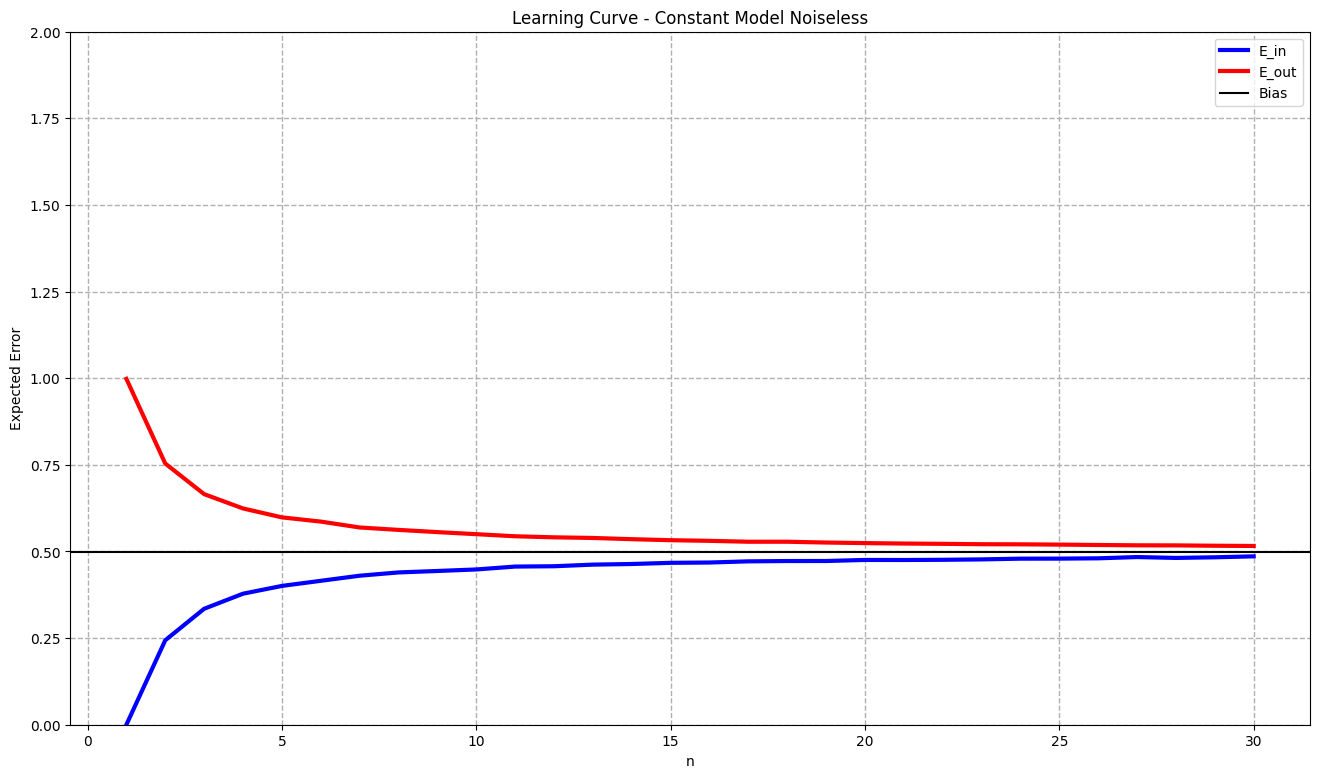

In [7]:
n = list(range(1,31))

plt.figure(figsize=(16,9))
plt.title("Learning Curve - Constant Model Noiseless")
plt.xlabel("n")
plt.ylabel("Expected Error")

plt.ylim(0,2)
plt.grid(linestyle='--', linewidth=1)

plt.plot(n, E_in_constant_no_noise, '-', color='b', linewidth=3, label='E_in')
plt.plot(n, E_out_constant_no_noise, '-', color='r', linewidth=3, label='E_out')

E_avg = (E_in_constant_no_noise[-1]+E_out_constant_no_noise[-1])/2
plt.axhline(y = bias, color = 'k', linestyle = '-', label='Bias')

plt.legend()

### Noisy (Run Noiseless first)

In [9]:
def bias_constant_model_sin_noise(avg_model,y_positions):
    bias = 0
    for i in range(len(y_positions)):
        bias += (avg_model -y_positions[i])**2
    bias /= len(y_positions)
    return bias

In [10]:
model_count = 5000
sigma = 0.5
E_in_constant_noise = []
E_out_constant_noise = []
for n in range(1,31):
    sample_model = []
    x_positions = []
    y_positions = []
    bias_list = []
    for i in range(model_count):
        x, y, x_sample, y_sample = random_constant_model(sin_pi,n,1,sigma)
        x_positions.append(x_sample)
        y_positions.append(y_sample)
        sample_model.append(y)
        bias_list.append(bias_constant_model_sin_noise(avg_model,y_sample))
    slope_sample = [0]*len(sample_model)
    avg_model = np.average(sample_model)
    var = var_constant_model(sample_model, avg_model)
    bias = np.average(bias_list)
    E_out_constant_noise.append(var+bias)
    E_in_constant_noise.append(E_in(slope_sample,sample_model,x_positions,y_positions))

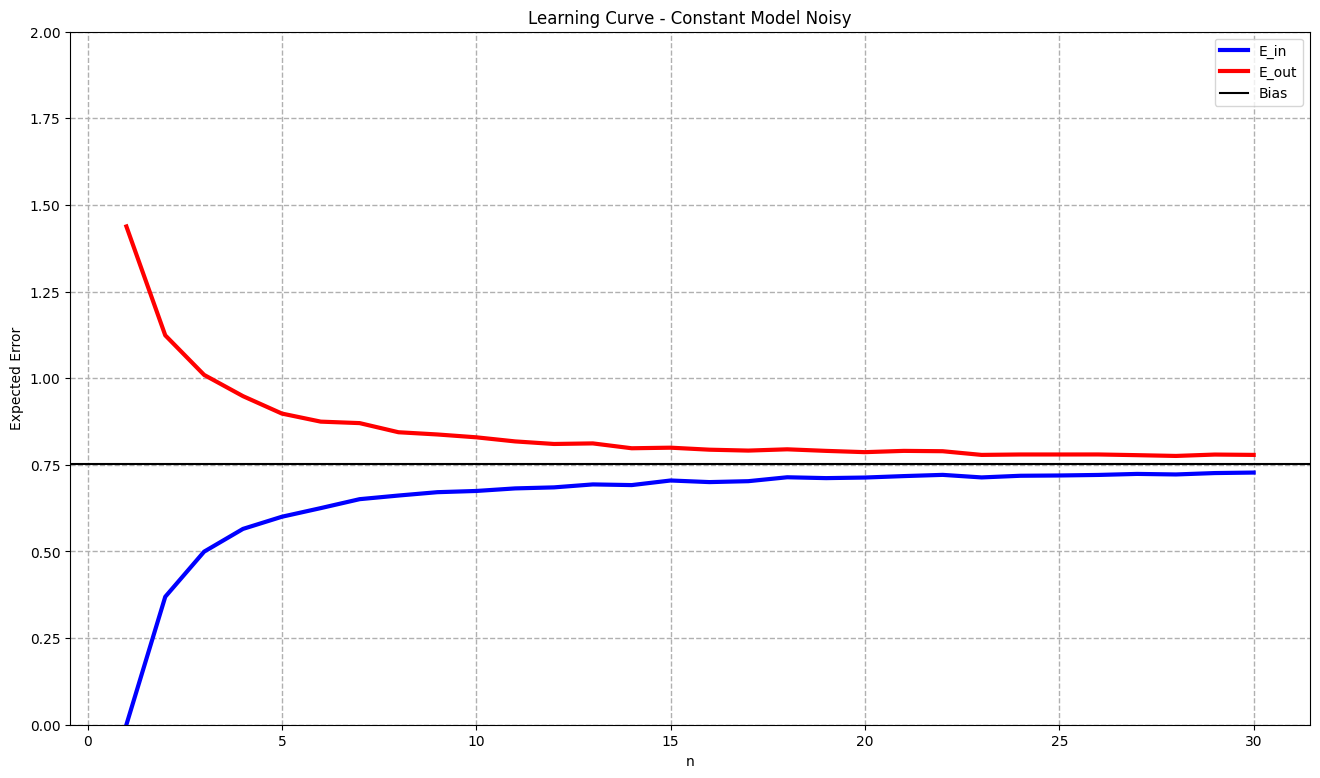

In [11]:
n = list(range(1,31))
plt.figure(figsize=(16,9))
plt.ylim(0,2)
plt.grid(linestyle='--', linewidth=1)

plt.title("Learning Curve - Constant Model Noisy")
plt.xlabel("n")
plt.ylabel("Expected Error")

plt.plot(n, E_in_constant_noise, '-', color='b', linewidth=3, label='E_in')
plt.plot(n, E_out_constant_noise, '-', color='r', linewidth=3, label='E_out')

# E_avg = (E_in_constant_noise[-1]+E_out_constant_noise[-1])/2
plt.axhline(y = bias, color = 'k', linestyle = '-', label='Bias')

plt.legend()

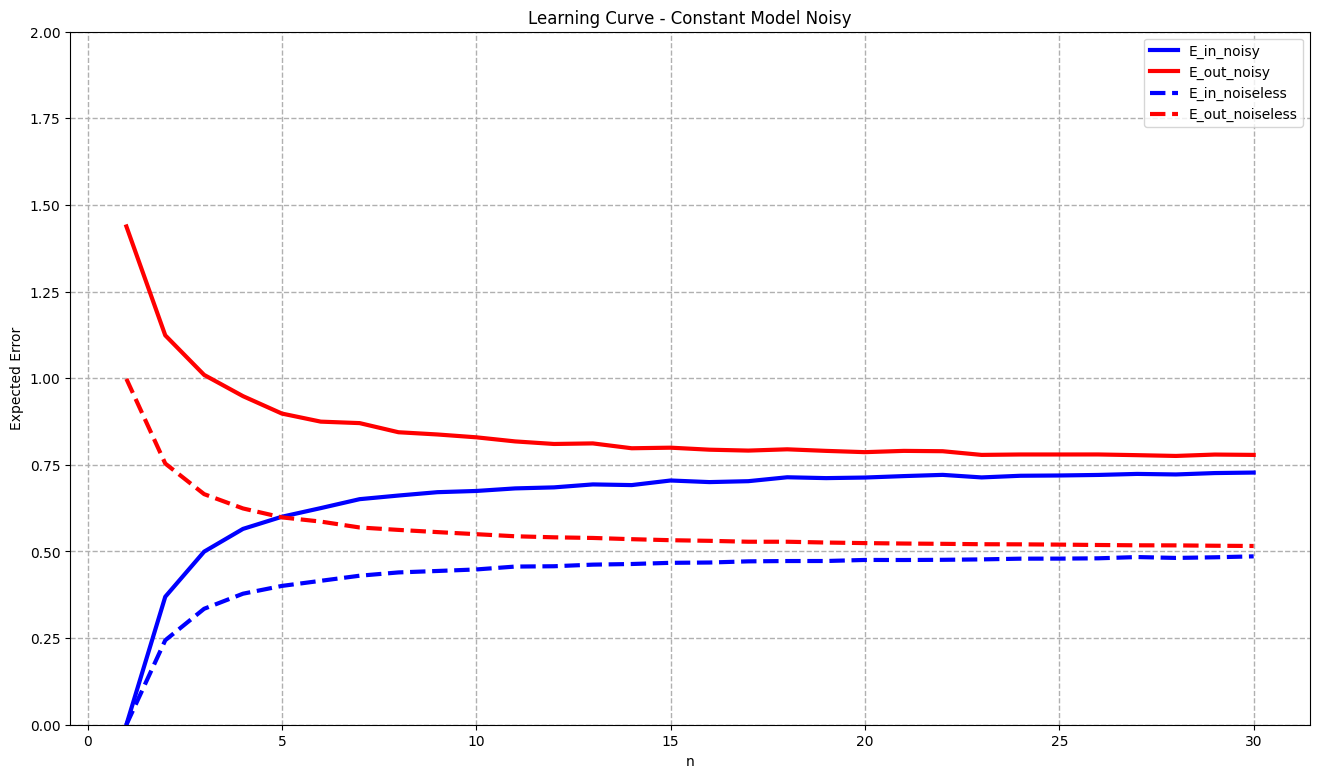

In [12]:
n = list(range(1,31))
plt.figure(figsize=(16,9))
plt.ylim(0,2)
plt.grid(linestyle='--', linewidth=1)

plt.title("Learning Curve - Constant Model Noisy")
plt.xlabel("n")
plt.ylabel("Expected Error")

plt.plot(n, E_in_constant_noise, '-', color='b', linewidth=3, label='E_in_noisy')
plt.plot(n, E_out_constant_noise, '-', color='r', linewidth=3, label='E_out_noisy')
plt.plot(n, E_in_constant_no_noise, '--', color='b', linewidth=3, label='E_in_noiseless')
plt.plot(n, E_out_constant_no_noise, '--', color='r', linewidth=3, label='E_out_noiseless')

plt.legend()

## Linear Model through the origin

### Noiseless

In [13]:
model_count = 5000
E_in_linear_origin_no_noise = []
E_out_linear_origin_no_noise = []
for n in range(1,31):
    slope_sample = []
    intercept_sample = []
    x_positions = []
    y_positions = []
    for i in range(model_count):
        slope, x_sample, y_sample = random_linear_origin_model(sin_pi, n)
        slope_sample.append(slope)
        intercept_sample.append(0)
        x_positions.append(x_sample)
        y_positions.append(y_sample)
    slope_avg = float(np.average(slope_sample))
    intercept_avg = float(np.average(intercept_sample))
    var = np.average(var_linear_model(slope_sample, intercept_sample, slope_avg, intercept_avg)[0])
    bias = bias_linear_model(slope_avg, intercept_avg, sin_pi)
    E_out_linear_origin_no_noise.append(var+bias)
    E_in_linear_origin_no_noise.append(E_in(slope_sample,intercept_sample,x_positions,y_positions))

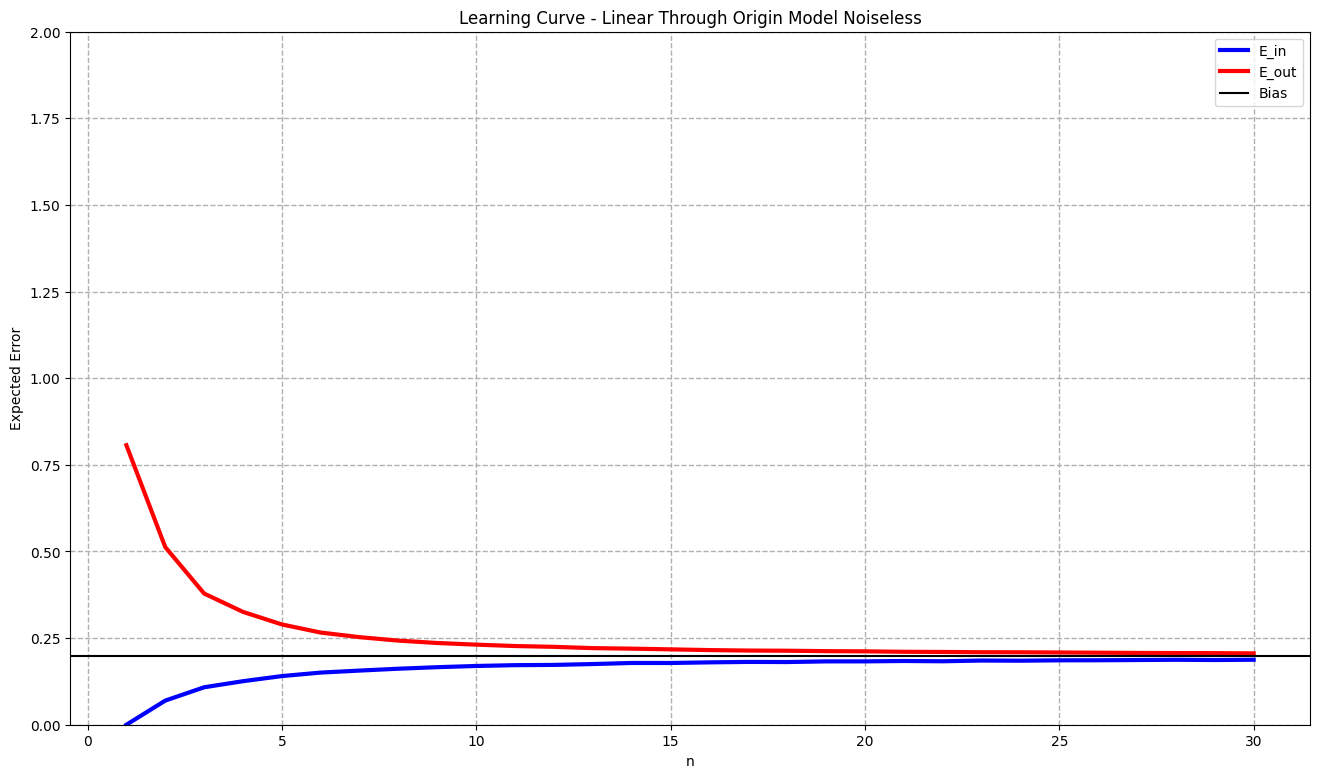

In [14]:
n = list(range(1,31))
plt.figure(figsize=(16,9))
plt.ylim(0,2)
plt.grid(linestyle='--', linewidth=1)

plt.title("Learning Curve - Linear Through Origin Model Noiseless")
plt.xlabel("n")
plt.ylabel("Expected Error")

plt.plot(n, E_in_linear_origin_no_noise, '-', color='b', linewidth=3, label='E_in')
plt.plot(n, E_out_linear_origin_no_noise, '-', color='r', linewidth=3, label='E_out')

# E_avg = (E_in_linear_origin_no_noise[-1]+E_out_linear_origin_no_noise[-1])/2
plt.axhline(y = bias, color = 'k', linestyle = '-', label='Bias')

plt.legend()

### Noisy (Run Noiseless first)

In [15]:
def bias_linear_model_sin_noise(slope_avg,intercept_avg,x_positions,y_positions):
    bias = 0
    for i in range(len(y_positions)):
        bias += ((slope_avg*x_positions[i] + intercept_avg) -y_positions[i])**2
    bias /= len(y_positions)
    return bias

In [21]:
model_count = 5000
sigma = 0.5
E_in_linear_origin_noise = []
E_out_linear_origin_noise = []
for n in range(1,31):
    slope_sample = []
    intercept_sample = []
    x_positions = []
    y_positions = []
    bias_list = []
    for i in range(model_count):
        slope, x_sample, y_sample = random_linear_origin_model(sin_pi,n,1,sigma)
        slope_sample.append(slope)
        intercept_sample.append(0)
        x_positions.append(x_sample)
        y_positions.append(y_sample)
        bias_list.append(bias_linear_model_sin_noise(slope_avg, intercept_avg,x_sample,y_sample))
    slope_avg = float(np.average(slope_sample))
    intercept_avg = float(np.average(intercept_sample))
    var = np.average(var_linear_model(slope_sample, intercept_sample, slope_avg, intercept_avg)[0])
    bias = np.average(bias_list)
    E_out_linear_origin_noise.append(var+bias)
    E_in_linear_origin_noise.append(E_in(slope_sample,intercept_sample,x_positions,y_positions))

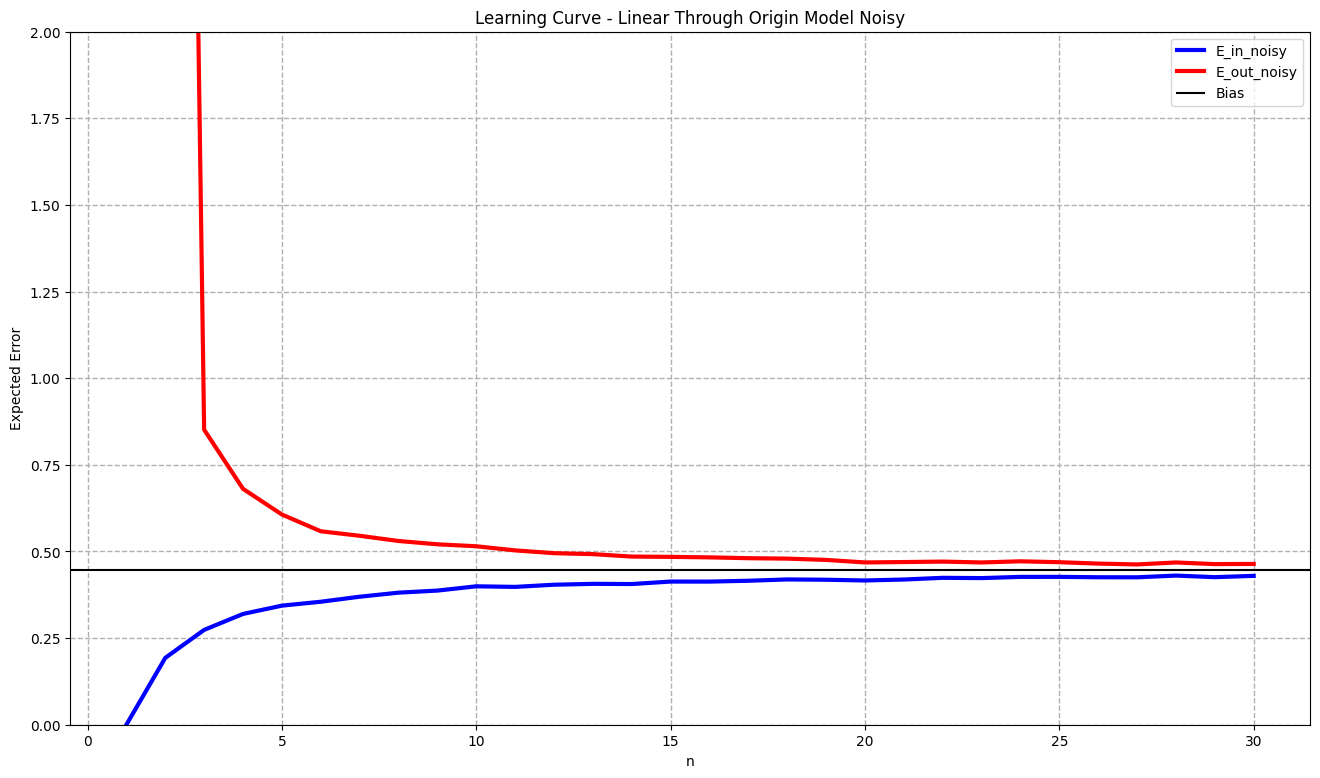

In [22]:
n = list(range(1,31))
plt.figure(figsize=(16,9))
plt.ylim(0,2)
plt.grid(linestyle='--', linewidth=1)

plt.title("Learning Curve - Linear Through Origin Model Noisy")
plt.xlabel("n")
plt.ylabel("Expected Error")

plt.plot(n, E_in_linear_origin_noise, '-', color='b', linewidth=3, label='E_in_noisy')
plt.plot(n, E_out_linear_origin_noise, '-', color='r', linewidth=3, label='E_out_noisy')

plt.axhline(y = bias, color = 'k', linestyle = '-', label='Bias')

plt.legend()

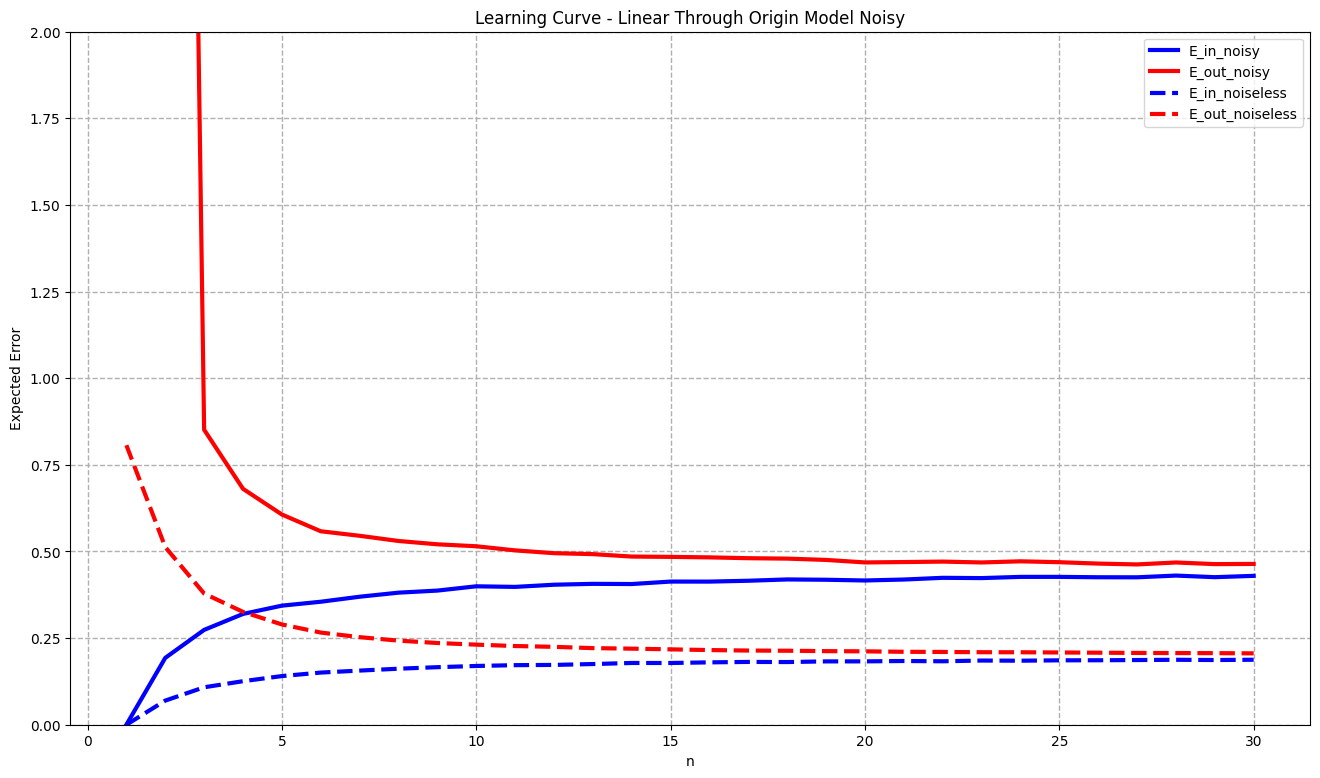

In [23]:
n = list(range(1,31))
plt.figure(figsize=(16,9))
plt.ylim(0,2)
plt.grid(linestyle='--', linewidth=1)

plt.title("Learning Curve - Linear Through Origin Model Noisy")
plt.xlabel("n")
plt.ylabel("Expected Error")

plt.plot(n, E_in_linear_origin_noise, '-', color='b', linewidth=3, label='E_in_noisy')
plt.plot(n, E_out_linear_origin_noise, '-', color='r', linewidth=3, label='E_out_noisy')
plt.plot(n, E_in_linear_origin_no_noise, '--', color='b', linewidth=3, label='E_in_noiseless')
plt.plot(n, E_out_linear_origin_no_noise, '--', color='r', linewidth=3, label='E_out_noiseless')

plt.legend()

## Linear Model

### Noiseless

In [11]:
model_count = 5000
E_in_linear_no_noise = []
E_out_linear_no_noise = []
for n in range(1,31):
    slope_sample = []
    intercept_sample = []
    x_positions = []
    y_positions = []
    for i in range(model_count):
        intercept, slope, x_sample, y_sample = random_linear_model(sin_pi,n)
        slope_sample.append(slope)
        intercept_sample.append(intercept)
        x_positions.append(x_sample)
        y_positions.append(y_sample)
    slope_avg = float(np.average(slope_sample))
    intercept_avg = float(np.average(intercept_sample))
    var = np.average(var_linear_model(slope_sample, intercept_sample, slope_avg, intercept_avg)[0])
    bias = bias_linear_model(slope_avg, intercept_avg, sin_pi)
    E_out_linear_no_noise.append(var+bias)
    E_in_linear_no_noise.append(E_in(slope_sample,intercept_sample,x_positions,y_positions))

c:\Users\supak\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
c:\Users\supak\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\supak\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


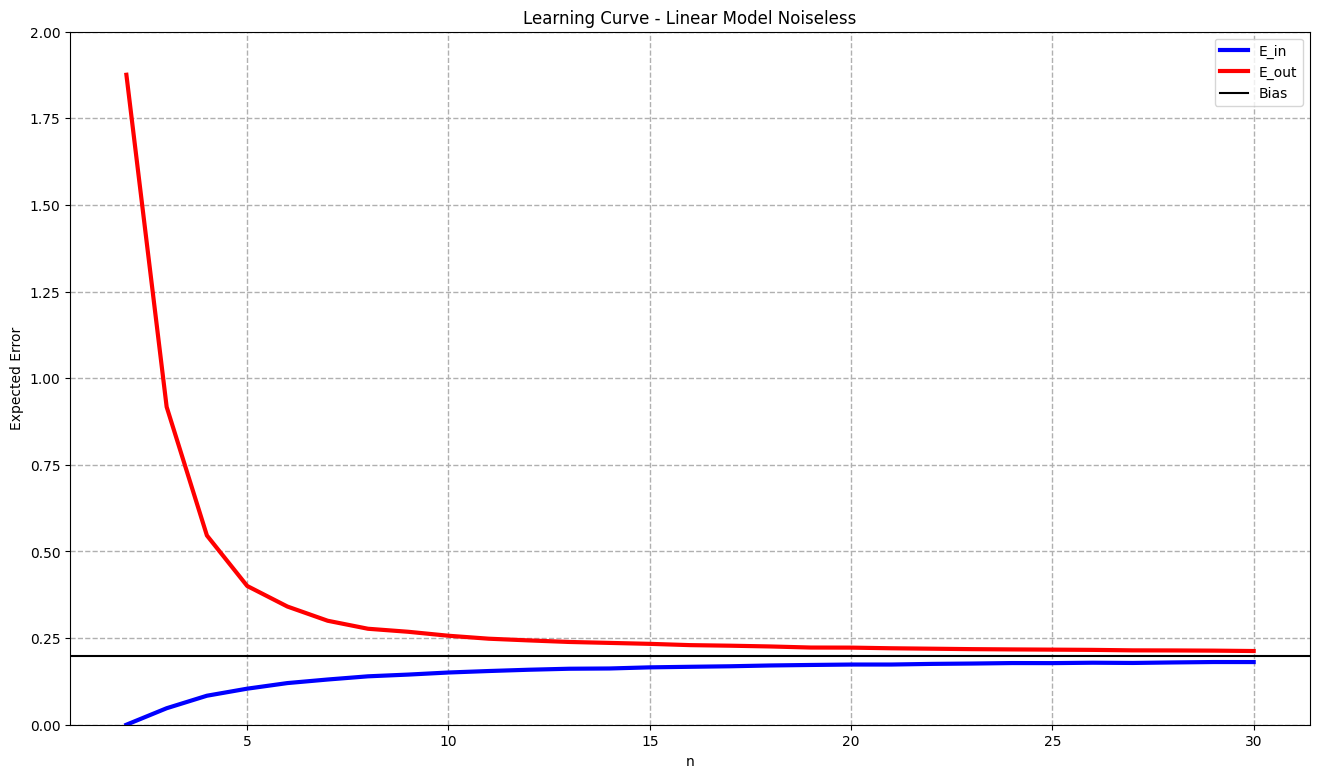

In [12]:
n = list(range(1,31))
plt.figure(figsize=(16,9))
plt.ylim(0,2)
plt.grid(linestyle='--', linewidth=1)

plt.title("Learning Curve - Linear Model Noiseless")
plt.xlabel("n")
plt.ylabel("Expected Error")

plt.plot(n, E_in_linear_no_noise, '-', color='b', linewidth=3, label='E_in')
plt.plot(n, E_out_linear_no_noise, '-', color='r', linewidth=3, label='E_out')

plt.axhline(y = bias, color = 'k', linestyle = '-', label='Bias')

plt.legend()

### Noisy (Run Noiseless first)

In [19]:
def bias_linear_model_sin_noise(slope_avg,intercept_avg,x_positions,y_positions):
    bias = 0
    for i in range(len(y_positions)):
        bias += ((slope_avg*x_positions[i] + intercept_avg) -y_positions[i])**2
    bias /= len(y_positions)
    return bias

In [26]:
model_count = 5000
sigma = 0.5
E_in_linear_noise = []
E_out_linear_noise = []
for n in range(1,31):
    slope_sample = []
    intercept_sample = []
    x_positions = []
    y_positions = []
    bias_list = []
    for i in range(model_count):
        intercept, slope, x_sample, y_sample = random_linear_model(sin_pi,n,1,sigma,100)
        slope_sample.append(slope)
        intercept_sample.append(intercept)
        x_positions.append(x_sample)
        y_positions.append(y_sample)
        bias_list.append(bias_linear_model_sin_noise(slope_avg, intercept_avg,x_sample,y_sample))
    slope_avg = float(np.average(slope_sample))
    intercept_avg = float(np.average(intercept_sample))
    var = np.average(var_linear_model(slope_sample, intercept_sample, slope_avg, intercept_avg)[0])
    bias = np.average(bias_list)
    E_out_linear_noise.append(var+bias)
    E_in_linear_noise.append(E_in(slope_sample,intercept_sample,x_positions,y_positions))

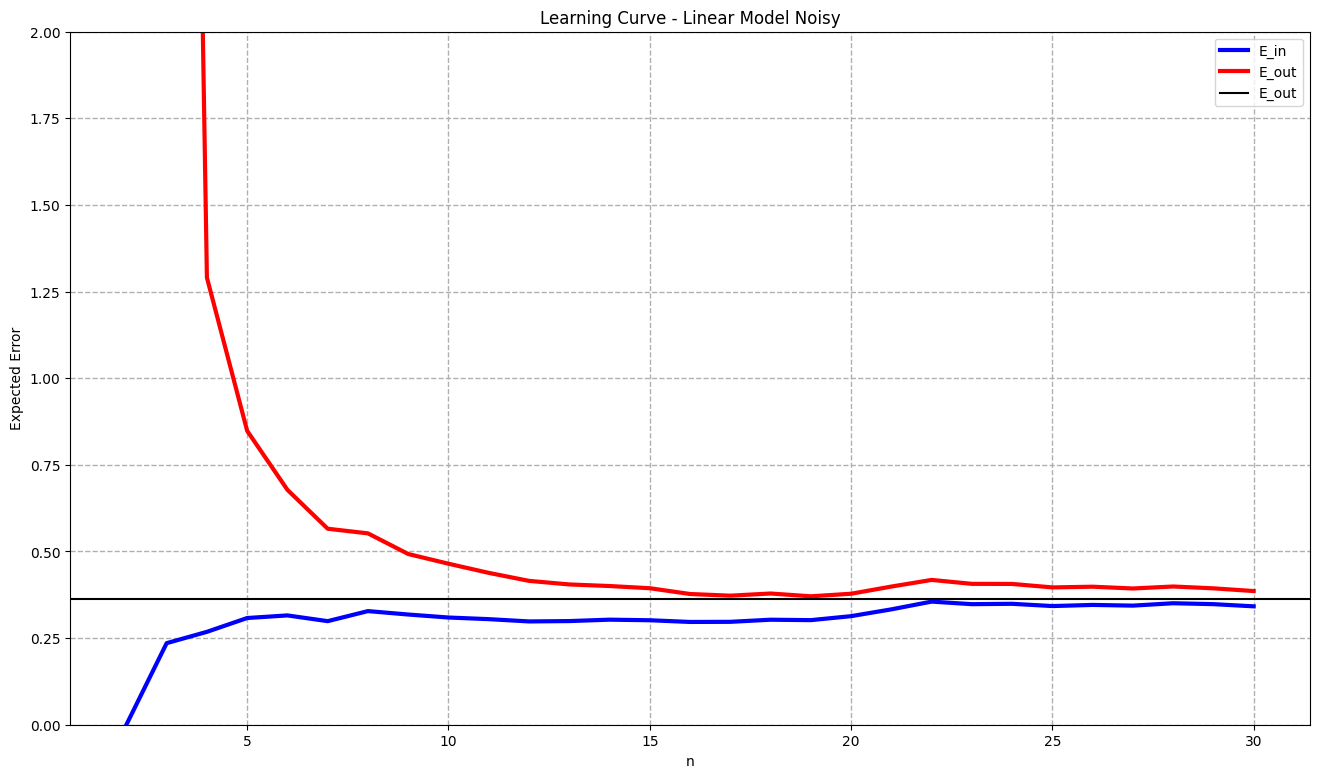

In [27]:
n = list(range(1,31))
plt.figure(figsize=(16,9))
plt.ylim(0,2)
plt.grid(linestyle='--', linewidth=1)

plt.title("Learning Curve - Linear Model Noisy")
plt.xlabel("n")
plt.ylabel("Expected Error")

plt.plot(n, E_in_linear_noise, '-', color='b', linewidth=3, label='E_in')
plt.plot(n, E_out_linear_noise, '-', color='r', linewidth=3, label='E_out')

# E_avg = (E_in_linear_noise[-1]+E_out_linear_noise[-1])/2
plt.axhline(y = bias, color = 'k', linestyle = '-', label='E_out')

plt.legend()

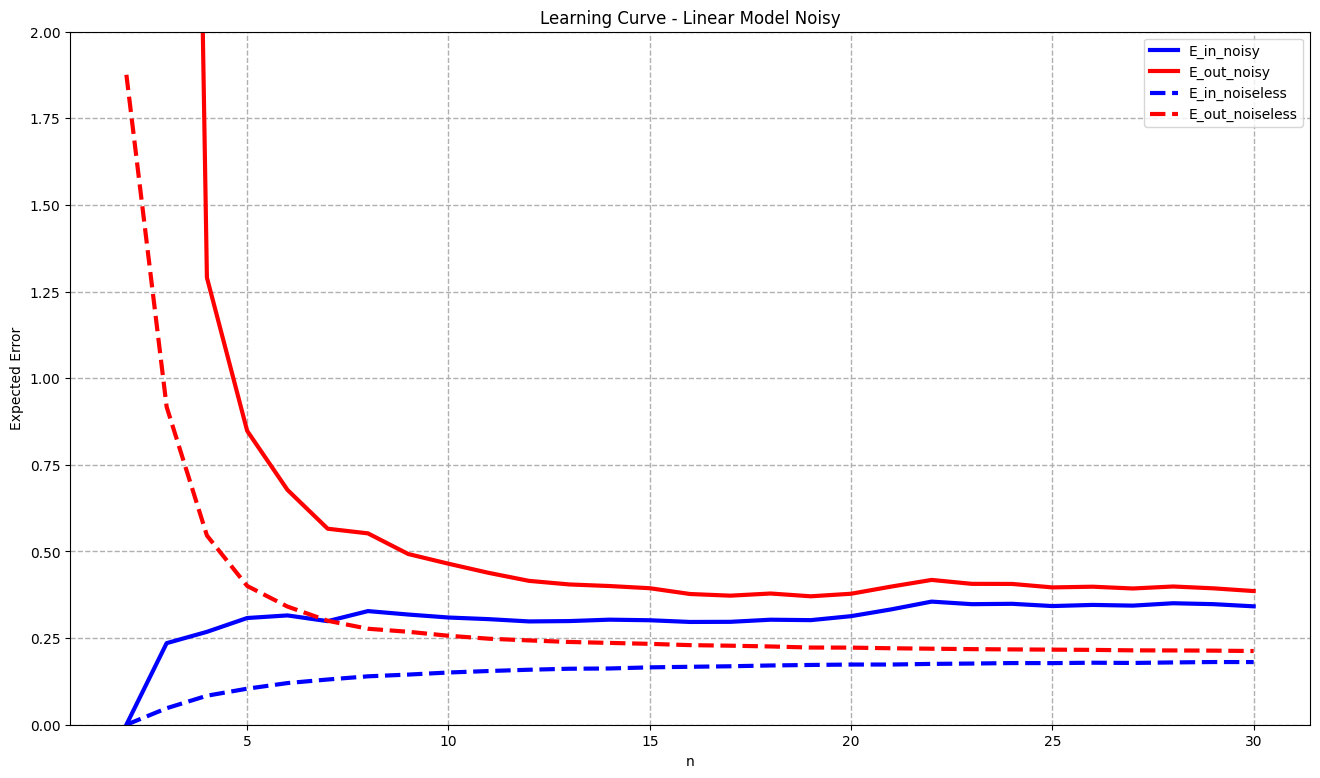

In [28]:
n = list(range(1,31))
plt.figure(figsize=(16,9))
plt.ylim(0,2)
plt.grid(linestyle='--', linewidth=1)

plt.title("Learning Curve - Linear Model Noisy")
plt.xlabel("n")
plt.ylabel("Expected Error")

plt.plot(n, E_in_linear_noise, '-', color='b', linewidth=3, label='E_in_noisy')
plt.plot(n, E_out_linear_noise, '-', color='r', linewidth=3, label='E_out_noisy')
plt.plot(n, E_in_linear_no_noise, '--', color='b', linewidth=3, label='E_in_noiseless')
plt.plot(n, E_out_linear_no_noise, '--', color='r', linewidth=3, label='E_out_noiseless')

plt.legend()